# Gaussian Process Regression


Let's set some setting for this Jupyter Notebook.

In [1]:
%matplotlib inline   
from warnings import filterwarnings
filterwarnings("ignore")
import os
os.environ['MKL_THREADING_LAYER'] = 'GNU'
os.environ['THEANO_FLAGS'] = 'device=cpu'    
    
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(12345)
rc = {'xtick.labelsize': 20, 'ytick.labelsize': 20, 'axes.labelsize': 20, 'font.size': 20, 
      'legend.fontsize': 12.0, 'axes.titlesize': 10, "figure.figsize": [12, 6]}
sns.set(rc = rc)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

 Now, let's import the `GaussianProcessRegression` algorithm from the `pymc-learn` package.

In [2]:
import pmlearn
from pmlearn.gaussian_process import GaussianProcessRegressor
print('Running on pymc-learn v{}'.format(pmlearn.__version__))

Running on pymc-learn v0.0.1.rc0


## Step 1: Prepare the data
Generate synthetic data.

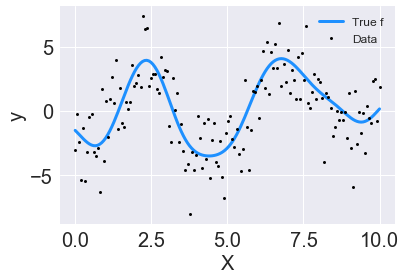

In [3]:
n = 150 # The number of data points
X = np.linspace(start = 0, stop = 10, num = n)[:, None] # The inputs to the GP, they must be arranged as a column vector

# Define the true covariance function and its parameters
length_scale_true = 1.0
signal_variance_true = 3.0
cov_func = signal_variance_true**2 * pm.gp.cov.ExpQuad(1, length_scale_true)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
# Note that we have to call `eval()` because PyMC3 built on top of Theano
f_true = np.random.multivariate_normal(mean_func(X).eval(),
                                       cov_func(X).eval() + 1e-8*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of Gaussian distributed noise
# The standard deviation of the noise is `sigma`
noise_variance_true = 2.0
y = f_true + noise_variance_true * np.random.randn(n)

## Plot the data and the unobserved latent function
fig = plt.figure()
ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Step 2: Instantiate a model

In [5]:
model = GaussianProcessRegressor()

In [6]:
model?

Type:        GaussianProcessRegressor
String form: GaussianProcessRegressor(kernel=None, prior_mean=None)
File:        ~/pymc-learn/pmlearn/gaussian_process/gpr.py
Docstring:  
Gaussian Process Regression built using PyMC3.

Fit a Gaussian process model and estimate model parameters using
MCMC algorithms or Variational Inference algorithms

Parameters
----------
prior_mean : mean object
    The mean specifying the mean function of the GP. If None is passed,
    the mean "pm.gp.mean.Zero()" is used as default.

Examples
--------
>>> from sklearn.datasets import make_friedman2
>>> from pmlearn.gaussian_process import GaussianProcessRegressor
>>> from pmlearn.gaussian_process.kernels import DotProduct, WhiteKernel
>>> X, y = make_friedman2(n_samples=500, noise=0, random_state=0)
>>> kernel = DotProduct() + WhiteKernel()
>>> gpr = GaussianProcessRegressor(kernel=kernel).fit(X, y)
>>> gpr.score(X, y) # doctest: +ELLIPSIS
0.3680...
>>> gpr.predict(X[:2,:], return_std=True) # doctest: +ELLIPS

## Step 3: Perform Inference

In [7]:
model.fit(X_train, y_train, inference_args={"n": 1000})

Average Loss = 416.16: 100%|██████████| 1000/1000 [00:02<00:00, 474.85it/s]
Finished [100%]: Average Loss = 415.55


GaussianProcessRegressor(kernel=None, prior_mean=None)

## Step 4: Diagnose convergence

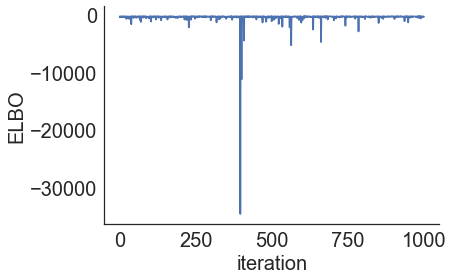

In [8]:
model.plot_elbo()

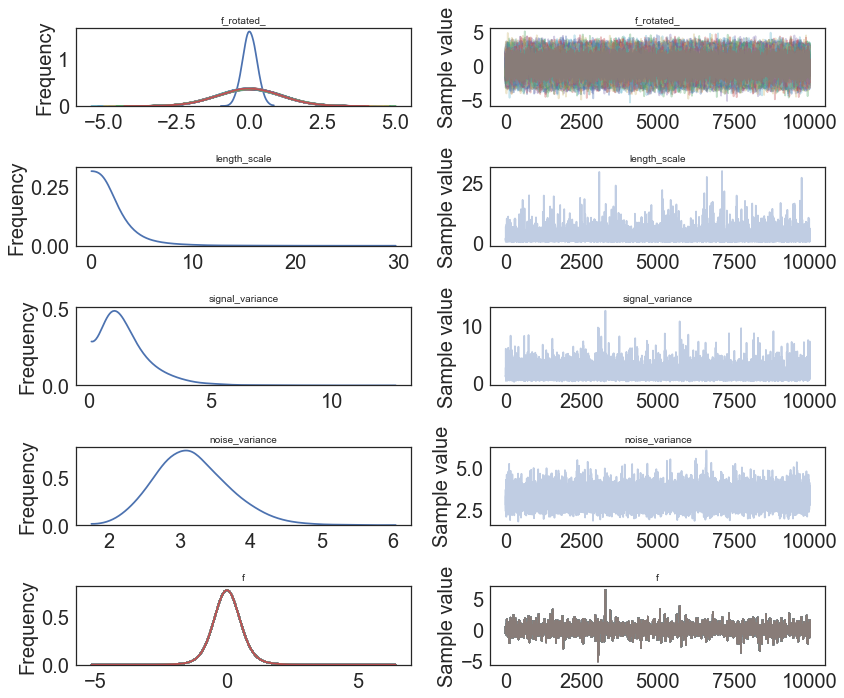

In [11]:
pm.traceplot(model.trace);

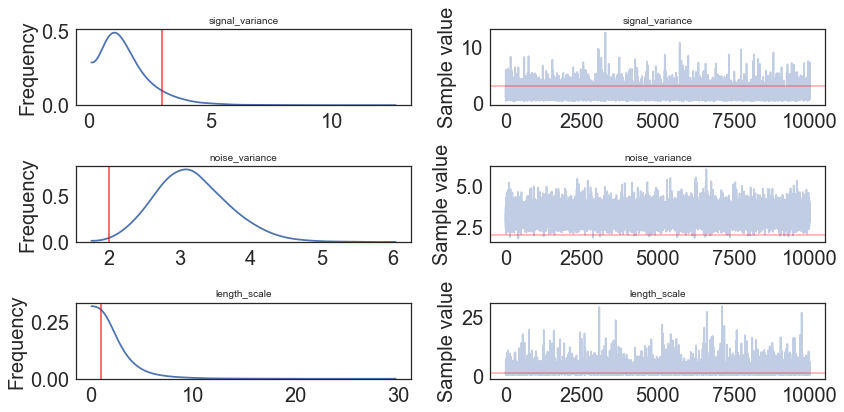

In [12]:
pm.traceplot(model.trace, lines = {"signal_variance": signal_variance_true, 
                                 "noise_variance": noise_variance_true, 
                                 "length_scale": length_scale_true}, 
             varnames=["signal_variance", "noise_variance", "length_scale"]);

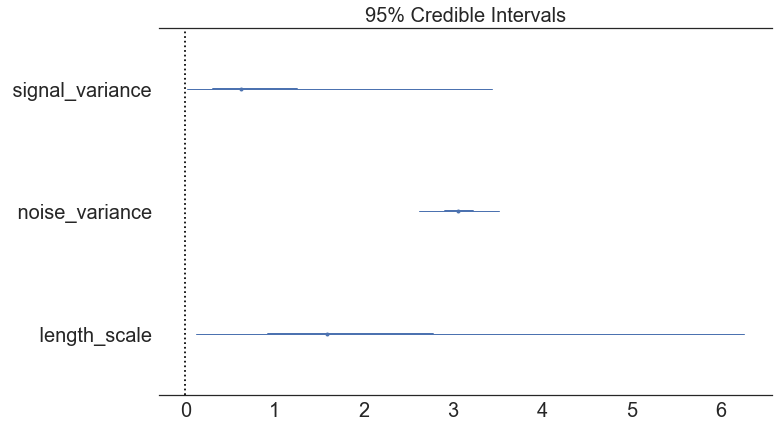

In [12]:
pm.forestplot(model.trace, varnames=["signal_variance", "noise_variance", "length_scale"]);

## Step 5: Critize the model

In [13]:
pm.summary(model.trace, varnames=["signal_variance", "length_scale", "noise_variance"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
signal_variance__0,1.069652,1.472790,0.014072,0.016441,3.442904
length_scale__0_0,2.252174,2.231719,0.025261,0.119457,6.266875
noise_variance__0,3.066997,0.231325,0.002249,2.622387,3.516474


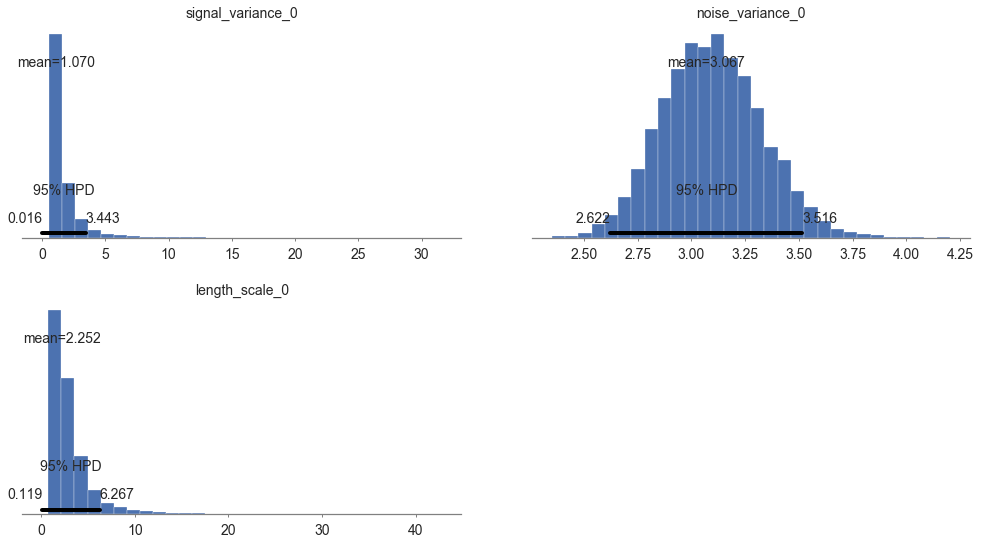

In [14]:
pm.plot_posterior(model.trace, varnames=["signal_variance", "noise_variance", "length_scale"], 
                 figsize = [14, 8]);

In [15]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["length_scale", "signal_variance", "noise_variance"],
              "Predicted Mean Value": [float(model.trace["length_scale"].mean(axis=0)), 
                               float(model.trace["signal_variance"].mean(axis=0)), 
                               float(model.trace["noise_variance"].mean(axis=0))],
              "True value": [length_scale_true, signal_variance_true, noise_variance_true]})

,Parameter,Predicted Mean Value,True value
0,length_scale,2.252174,1.0
1,signal_variance,1.069652,3.0
2,noise_variance,3.066997,2.0


## Step 6: Use the model for prediction

In [9]:
y_predict1 = model.predict(X_test)

100%|██████████| 2000/2000 [00:14<00:00, 135.47it/s]


In [10]:
y_predict1

array([ 0.00166453,  0.07415753,  0.07185864,  0.01505948,  0.02280044,
       -0.00041549, -0.02338406,  0.01753743,  0.02065263,  0.00825294,
        0.02449021,  0.06761137,  0.04990807,  0.01614856, -0.03135927,
       -0.00813461,  0.04545187, -0.03770688,  0.06116857,  0.06864128,
        0.04164327, -0.01700696,  0.01389948, -0.02395358, -0.01853882,
       -0.02147422,  0.05869176, -0.02825002,  0.01058576,  0.04180517,
        0.01563565, -0.0086748 ,  0.01048786, -0.02464047,  0.0639958 ,
       -0.02110329, -0.03658159,  0.0552832 , -0.00030839,  0.03097778,
        0.00415975,  0.05252889,  0.00894602,  0.06400553, -0.05004306])

In [ ]:
model.score(X_test, y_test)

In [12]:
model.save('pickle_jar/gpr')

#### Use already trained model for prediction

In [13]:
model_new = GaussianProcessRegressor()
model_new.load('pickle_jar/gpr')
model_new.score(X_test, y_test)

100%|██████████| 2000/2000 [00:14<00:00, 136.18it/s]


-0.0049724872177634438

## Multiple Features

In [14]:
num_pred = 2
X = np.random.randn(1000, num_pred)
noise = 2 * np.random.randn(1000,)
Y = X.dot(np.array([4, 5])) + 3 + noise

In [15]:
y = np.squeeze(Y)

In [16]:
model_big = GaussianProcessRegressor()

In [17]:
model_big.fit(X, y, inference_args={"n" : 1000})

Average Loss = 6,077.1: 100%|██████████| 1000/1000 [02:17<00:00,  7.11it/s]
Finished [100%]: Average Loss = 6,056.9


GaussianProcessRegressor(prior_mean=0.0)

In [18]:
pm.summary(model_big.trace, varnames=["signal_variance", "length_scale", "noise_variance"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
signal_variance__0,5.420972,4.049228,0.041386,0.635510,12.967287
length_scale__0_0,2.460546,2.034025,0.021939,0.192283,6.279051
length_scale__0_1,2.437830,1.994458,0.018703,0.267447,6.202378
noise_variance__0,7.173519,4.732447,0.042548,0.936711,16.368718


## MCMC

### Perform inference

In [ ]:
model2 = GaussianProcessRegressor()
model2.fit(X_train, y_train, inference_type='nuts')

### Diagnose convergence

In [ ]:
pm.traceplot(model2.trace, lines = {"signal_variance": signal_variance_true, 
                                 "noise_variance": noise_variance_true, 
                                 "length_scale": length_scale_true}, 
             varnames=["signal_variance", "noise_variance", "length_scale"]);

In [ ]:
pm.gelman_rubin(model2.trace, varnames=["signal_variance", "noise_variance", "length_scale"])

In [ ]:
pm.energyplot(model2.trace);

In [ ]:
pm.forestplot(model2.trace, varnames=["signal_variance", "noise_variance", "length_scale"]);

### Criticize the model

In [ ]:
pm.summary(model2.trace, varnames=["signal_variance", "length_scale", "noise_variance"])

In [ ]:
# collect the results into a pandas dataframe to display
# "mp" stands for marginal posterior
pd.DataFrame({"Parameter": ["length_scale", "signal_variance", "noise_variance"],
              "Predicted Mean Value": [float(model2.trace["length_scale"].mean(axis=0)), 
                               float(model2.trace["signal_variance"].mean(axis=0)), 
                               float(model2.trace["noise_variance"].mean(axis=0))],
              "True value": [length_scale_true, signal_variance_true, noise_variance_true]})

In [ ]:
pm.plot_posterior(model2.trace, varnames=["signal_variance", "noise_variance", "length_scale"], 
                 figsize = [14, 8]);

### Use the model for prediction

In [ ]:
y_predict2 = model2.predict(X_test)

In [ ]:
y_predict2

In [ ]:
model2.score(X_test, y_test)

In [ ]:
model2.save('pickle_jar/gpr2')
model2_new = GaussianProcessRegressor
model2_new.load('pickle_jar//gpr2')
model2_new.score(X_test, y_test)